In [1]:
import os
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np


In [3]:
# !pip freeze

In [2]:
IMAGE_SIZE = (28, 28)  # Adjust the size as per your dataset
BATCH_SIZE = 32
DATA_DIR = os.path.join("Digits1")
LOG_DIR =os.path.join("logs2")
SAVEDIR = os.path.join("savedModel2")

In [3]:
dataset=tf.keras.utils.image_dataset_from_directory(DATA_DIR,seed =10, color_mode ="grayscale")

n_classes= len(dataset.class_names)
print(n_classes)
# dataset.class_names= [int(x) for x in (dataset.class_names)]

dataset.class_names


Found 52160 files belonging to 10 classes.
10


['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

image shape:  (256, 256, 1)


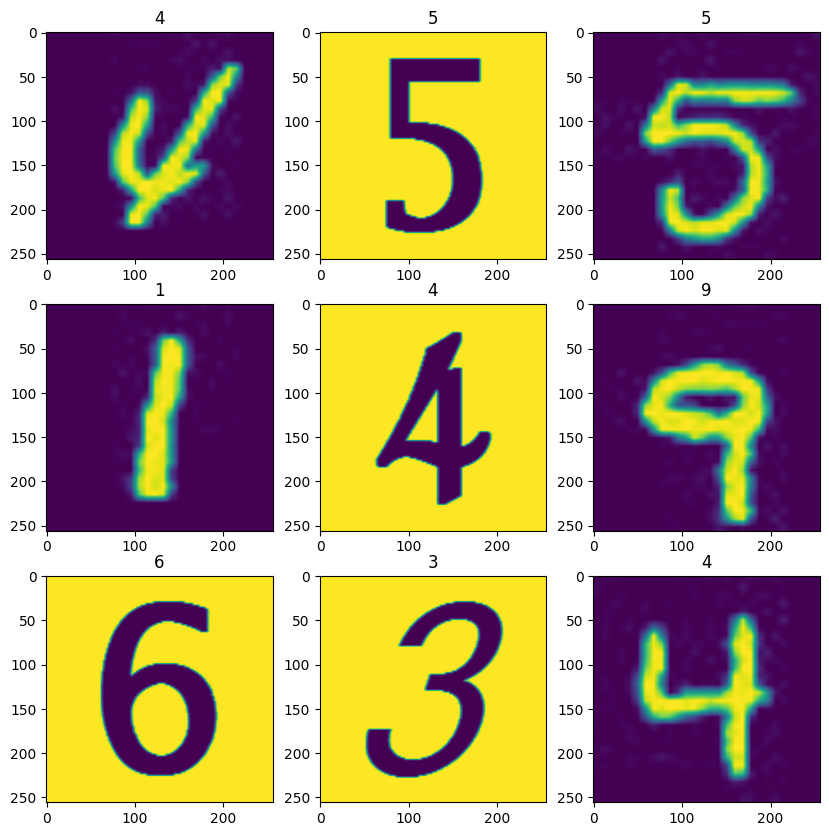

In [4]:
plt.figure(figsize =(10,10))

for item in dataset.take(1):
    images, labels = item
    print("image shape: ", images[0].shape)
    
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(labels[i].numpy())
        
    plt.show()



In [5]:
DATASET_SIZE = tf.data.experimental.cardinality(dataset).numpy() #Total number of batches
train_size = int(0.7 * DATASET_SIZE)
test_size = int(0.15 * DATASET_SIZE)
val_size = int(DATASET_SIZE-(train_size+test_size))
print(train_size)
print(val_size)
print(test_size)
print("Total batches =", train_size+val_size+test_size)

1141
245
244
Total batches = 1630


In [6]:
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size).take(val_size)
test_dataset = dataset.skip(train_size+val_size)
# print(len(train_dataset))
# print(len(val_dataset))
# print(len(test_dataset))


In [7]:
class_counts = {key:0 for key in range(10) }
for item in train_dataset:
    imgs, lbls = item
    for label in lbls:
        # print(type(label.numpy()))
        
        class_counts[label.numpy()] +=1 
    
class_counts

{0: 3614,
 1: 4016,
 2: 3575,
 3: 3825,
 4: 3627,
 5: 3355,
 6: 3555,
 7: 3800,
 8: 3538,
 9: 3607}

In [8]:
#Standardization layer

ImageStandardize = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE[0], IMAGE_SIZE[1]),
    layers.Rescaling(scale = 1/255.)
])

In [9]:
#Augmentation layer
ImageAugment = tf.keras.Sequential([
    # layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 1)),
    layers.RandomTranslation(height_factor = 0.10,width_factor = 0.15),
    layers.RandomRotation(factor = 0.1),
    layers.RandomZoom(height_factor = 0.10),
    layers.RandomContrast(factor = 0.3)
])

(9, 28, 28, 1)
(9, 28, 28, 1)
(9, 28, 28, 1)
(9, 28, 28, 1)
(9, 28, 28, 1)
(9, 28, 28, 1)
(9, 28, 28, 1)
(9, 28, 28, 1)
(9, 28, 28, 1)
(9, 28, 28, 1)
(9, 28, 28, 1)
(9, 28, 28, 1)
(9, 28, 28, 1)
(9, 28, 28, 1)
(9, 28, 28, 1)
(9, 28, 28, 1)
(9, 28, 28, 1)
(9, 28, 28, 1)


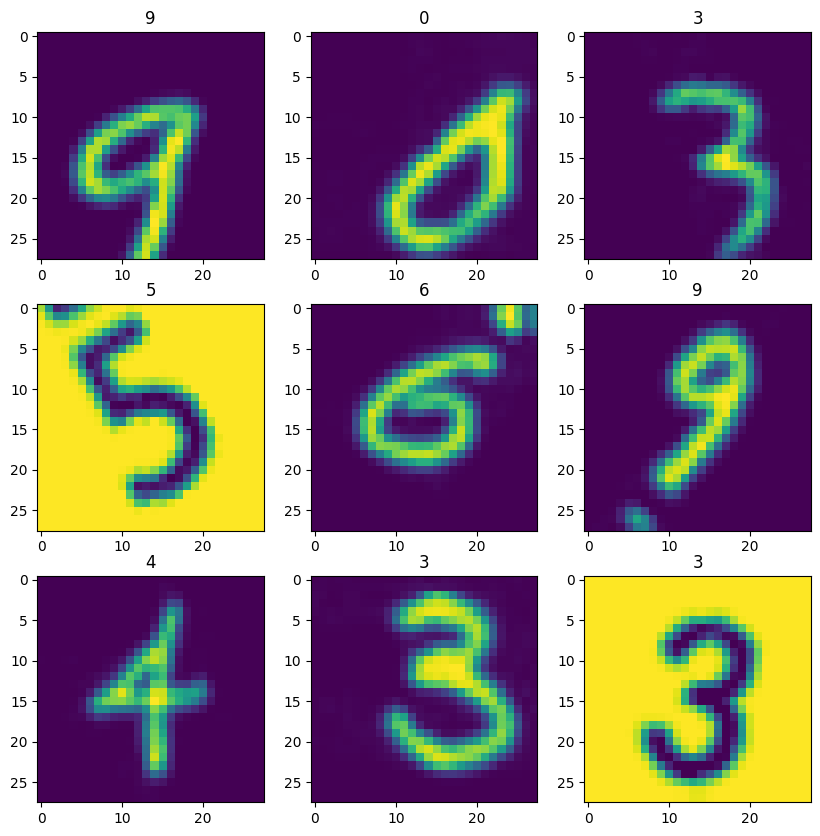

In [10]:
#Standardized and Augmented images
data_iterator = dataset.as_numpy_iterator()
img_array, lbls_array = data_iterator.next()
imgs =img_array[:9]
lbls =lbls_array[:9]

plt.figure(figsize =(10,10))
for i in range(9):
    ax = plt.subplot(3,3,i+1)
    std_img= ImageStandardize(imgs)
    # image = tf.cast(tf.expand_dims(std_img, 0), tf.float32)
    aug_img = ImageAugment(std_img)
    print(std_img.shape)
    print(aug_img.shape)
    plt.imshow((aug_img[i]))
    plt.title(lbls[i])
    


In [13]:
def myModel(n_classes):
    n_filter = 32
    filterSize1 = (5, 5)
    filterSize2 = (3, 3)
    poolSize = (2, 2)
    n_denseUnits = 500

    model = tf.keras.Sequential([
        ImageStandardize,
        ImageAugment,
        layers.Conv2D(n_filter, filterSize1, activation='relu'),
        layers.Conv2D(n_filter, filterSize1, activation='relu'),
        layers.MaxPooling2D(pool_size=poolSize),
        layers.Conv2D(n_filter* 2, filterSize2, activation='relu'),
        layers.Conv2D(n_filter* 2, filterSize2, activation='relu'),
        layers.MaxPooling2D(pool_size=poolSize),
        layers.Dropout(0.5),
        layers.Flatten(),
        layers.Dense(n_denseUnits, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(n_classes, activation='softmax')
    ])

    return model

model = myModel(10)
model.build(input_shape=(None, IMAGE_SIZE[0], IMAGE_SIZE[1], 1))  
# model.build()  
model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 28, 28, 1)         0         
                                                                 
 sequential_1 (Sequential)   (None, 28, 28, 1)         0         
                                                                 
 conv2d_8 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 conv2d_9 (Conv2D)           (None, 20, 20, 32)        25632     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 10, 10, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 8, 8, 64)          18496     
                                                      

In [ ]:
# def myModel(n_classes):
#     n_filter = 60
#     filterSize1 = (5, 5)
#     filterSize2 = (3, 3)
#     poolSize = (2, 2)
#     n_denseUnits = 500

#     model = tf.keras.Sequential([
#         ImageStandardize,
#         ImageAugment,
#         layers.Conv2D(n_filter, filterSize1, activation='relu'),
#         layers.Conv2D(n_filter, filterSize1, activation='relu'),
#         layers.MaxPooling2D(pool_size=poolSize),
#         layers.Conv2D(n_filter // 2, filterSize2, activation='relu'),
#         layers.Conv2D(n_filter // 2, filterSize2, activation='relu'),
#         layers.MaxPooling2D(pool_size=poolSize),
#         layers.Dropout(0.5),
#         layers.Flatten(),
#         layers.Dense(n_denseUnits, activation='relu'),
#         layers.Dropout(0.5),
#         layers.Dense(n_classes, activation='softmax')
#     ])

#     return model

# model = myModel(10)
# model.build(input_shape=(None, IMAGE_SIZE[0], IMAGE_SIZE[1], 1))  
# model.summary()


In [14]:
model.compile('adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [15]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(LOG_DIR)

In [16]:
history = model.fit(train_dataset, epochs=200, validation_data=val_dataset, callbacks=[tensorboard_callback])



Epoch 1/200


1141/1141 [==============================] - 29s 25ms/step - loss: 0.8410 - accuracy: 0.7212 - val_loss: 0.1352 - val_accuracy: 0.9523
Epoch 2/200
1141/1141 [==============================] - 28s 24ms/step - loss: 0.3146 - accuracy: 0.9039 - val_loss: 0.0816 - val_accuracy: 0.9740
Epoch 3/200
1141/1141 [==============================] - 28s 24ms/step - loss: 0.2486 - accuracy: 0.9253 - val_loss: 0.0675 - val_accuracy: 0.9770
Epoch 4/200
1141/1141 [==============================] - 29s 25ms/step - loss: 0.2088 - accuracy: 0.9364 - val_loss: 0.0663 - val_accuracy: 0.9790
Epoch 5/200
1141/1141 [==============================] - 30s 26ms/step - loss: 0.1912 - accuracy: 0.9433 - val_loss: 0.0692 - val_accuracy: 0.9781
Epoch 6/200
1141/1141 [==============================] - 30s 27ms/step - loss: 0.1713 - accuracy: 0.9503 - val_loss: 0.0686 - val_accuracy: 0.9795
Epoch 7/200
1141/1141 [==============================] - 31s 27ms/step - loss: 0.1689 - accuracy: 0.9497 - val_loss: 0.0578 - val_

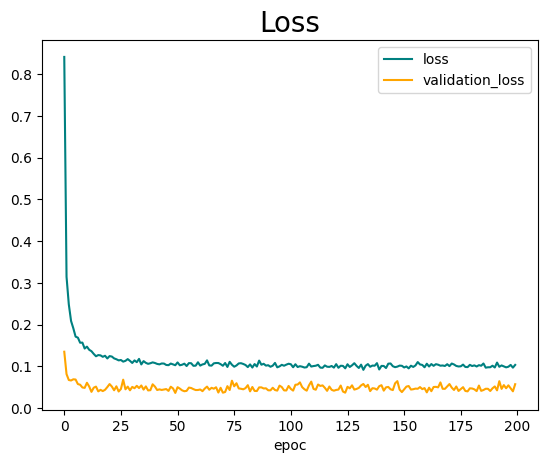

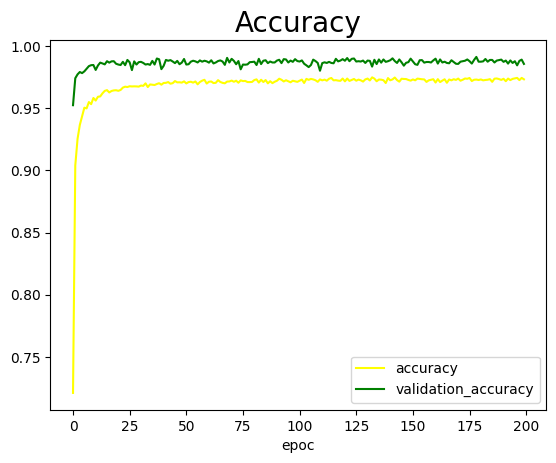

In [17]:
fig1= plt.figure(1)
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='validation_loss')
plt.title('Loss', fontsize=20)
plt.xlabel('epoc')
plt.legend()

fig2 = plt.figure(2)
plt.plot(history.history['accuracy'], color='yellow', label='accuracy')
plt.plot(history.history['val_accuracy'], color='green', label='validation_accuracy')
plt.title('Accuracy', fontsize=20)
plt.xlabel('epoc')
plt.legend()
plt.show()

In [18]:
score = model.evaluate(test_dataset)

244/244 [==============================] - 5s 7ms/step - loss: 0.0481 - accuracy: 0.9886


In [19]:
print("Test score = ", score[0])
print("Test accuracy = ", score[1])


Test score =  0.04811032861471176
Test accuracy =  0.9886014461517334


In [25]:
# model.save(SAVEDIR,save_format='tf')
# model.save('digitPredModel.h5', save_format='h5')
model.save('digitModel.keras')

In [27]:
new_model = tf.keras.models.load_model('digitModel.keras')
new_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 28, 28, 1)         0         
                                                                 
 sequential_1 (Sequential)   (None, 28, 28, 1)         0         
                                                                 
 conv2d_8 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 conv2d_9 (Conv2D)           (None, 20, 20, 32)        25632     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 10, 10, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 8, 8, 64)          18496     
                                                      

In [38]:
import cv2
img = cv2.imread("test_6.jpg", 0)
img = cv2.resize(img, (28,28))
img = np.asarray([img])
img = np.expand_dims(img, -1)
print(img.shape)
# cv2.imshow('test image',img)
# cv2.waitKey(0)

(1, 28, 28, 1)


In [39]:
pred =new_model.predict(img)
np.argmax(pred)

1/1 [==============================] - 0s 13ms/step


8